![](https://upload.wikimedia.org/wikipedia/commons/1/1a/Tyre_Marks_in_the_Sand_-_geograph.org.uk_-_1546451.jpg)

# Quick Problem Description
Link every *track* to one *hit*.

*Disclaimer: I'm oversimplifying physics to explain this problem*.

Every particle leaves a track behind it, like a car leaving tire marks in the sand.  We did not catch the particle in action.  Now we want to link every track (tire mark) to one hit that the particle created.

In every **event**, a large number of **particles** are released.  They move along a path leaving behind their **tracks**.  They eventually **hit** a particle detector surface on the other end.

In the training data we have the following information on each **event**:
- **Hits**: $x, y, z$ coordinates of each hit on the particle detector
- **Particles**: Each particle's initial position ($v_x, v_y, v_z$), momentum ($p_x, p_y, p_z$), charge ($q$) and number of hits
- **Truth**: Mapping between hits and generating particles; the particle's trajectory, momentum and the hit weight
- **Cells**: Precise location of where each particle hit the detector and how much energy it deposited

# Data Exploration:
#### Import `trackml-library`
The easiest and best way to load the data is with the [trackml-library] that was built for this purpose.

Under your kernel's *Settings* tab -> *Add a custom package* -> *GitHub user/repo* (LAL/trackml-library)

Restart your  kernel'
s session and you will be good to go.

[trackml-library]: https://github.com/LAL/trackml-library

In [7]:
import os

import numpy as np
import pandas as pd

from trackml.dataset import load_event
from trackml.randomize import shuffle_hits
from trackml.score import score_event

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
%matplotlib inline

In [8]:
#event_prefix = 'event000001000'
#hits, cells, particles, truth = load_event(os.path.join('../trackmldataset', event_prefix))
hits, cells, particles, truth = load_event('./trackmldataset/event000001000')

mem_bytes = (hits.memory_usage(index=True).sum() 
             + cells.memory_usage(index=True).sum() 
             + particles.memory_usage(index=True).sum() 
             + truth.memory_usage(index=True).sum())
print('{} memory usage {:.2f} MB'.format(event_prefix, mem_bytes / 2**20))

event000001000 memory usage 18.46 MB


## Hits Data
### Where Did it Hit?
Here we have the $x, y, z$ global coordinates (in millimeters) of where the particles hit the detector surface.

In [9]:
hits.head()

,hit_id,x,y,z,volume_id,layer_id,module_id
0,1,-64.409897,-7.163700,-1502.5,7,2,1
1,2,-55.336102,0.635342,-1502.5,7,2,1
2,3,-83.830498,-1.143010,-1502.5,7,2,1
3,4,-96.109100,-8.241030,-1502.5,7,2,1
4,5,-62.673599,-9.371200,-1502.5,7,2,1


Here is the distribution of $x, y, z$ location of hits in event 1000.  This is only for one out of 8,850 events.

### Vertical Intersection ($x, y$) in Detection Layers
As shown in the figure below, the hits are semi evenly distributed on the detector surface $x, y$.  The white circle in the center of the plot is where the beam pipe lies.  Thanks [agerom] for [the clarification][clar].

The colors represent different detector volumes.  Thanks to [Joshua Bonatt's notebook][josh].

[josh]: https://www.kaggle.com/jbonatt/trackml-eda-etc
[clar]: https://www.kaggle.com/wesamelshamy/trackml-problem-explanation-and-data-exploration/comments#323803
[agerom]: https://www.kaggle.com/artemiosgeromitsos

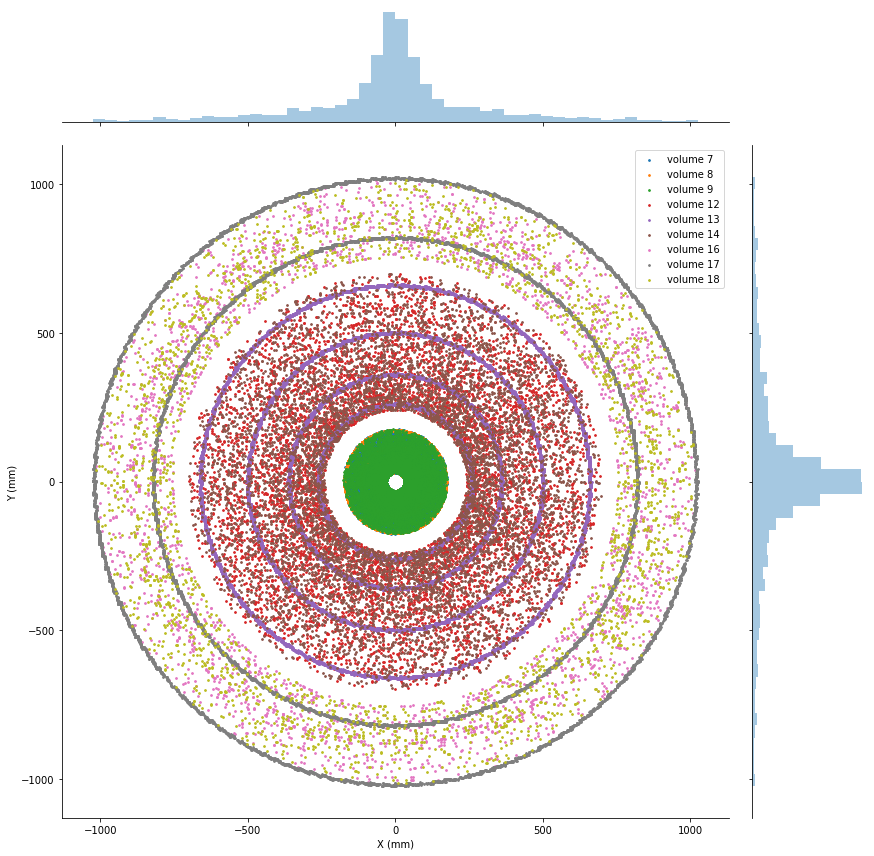

In [10]:
g = sns.jointplot(hits.x, hits.y,  s=1, size=12)
g.ax_joint.cla()
plt.sca(g.ax_joint)

volumes = hits.volume_id.unique()
for volume in volumes:
    v = hits[hits.volume_id == volume]
    plt.scatter(v.x, v.y, s=3, label='volume {}'.format(volume))

plt.xlabel('X (mm)')
plt.ylabel('Y (mm)')
plt.legend()
plt.show()

### Horizonal Intersection ($y, z$) in Detection Layers
You can think of the chart below as a horizontal intersection in the detection surface, where every dot is a hit.  Notice the relationship between the different activity levels in this chart and the one above for $x, y$.

Again, the colors represent different volumes in the detector surface.

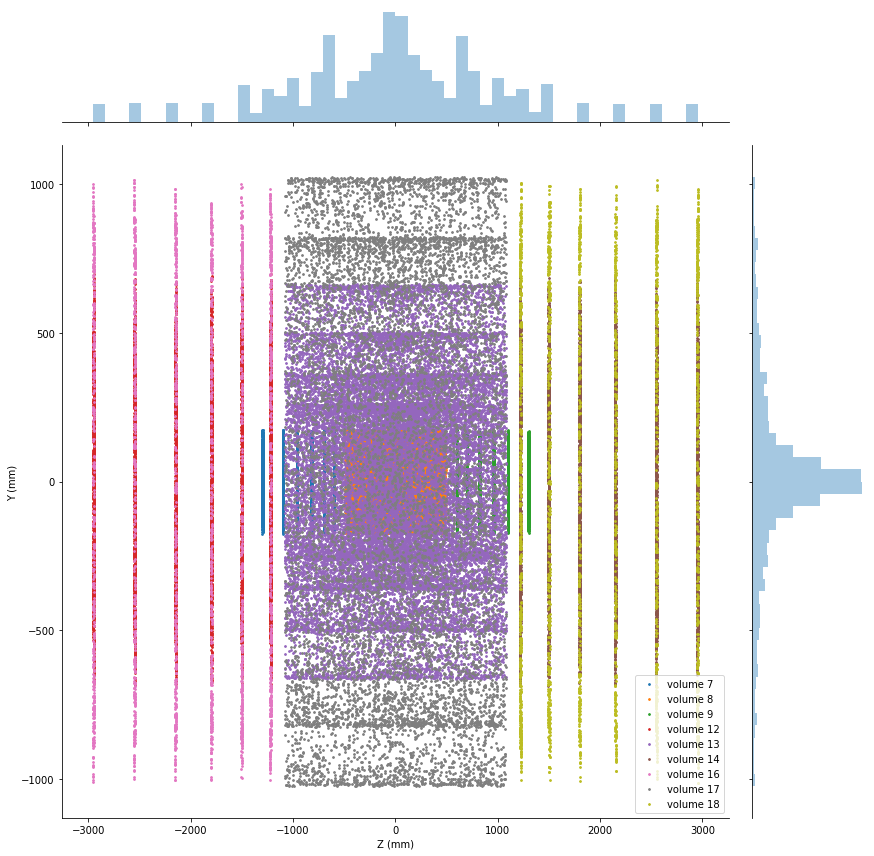

In [11]:
g = sns.jointplot(hits.z, hits.y, s=1, size=12)
g.ax_joint.cla()
plt.sca(g.ax_joint)

volumes = hits.volume_id.unique()
for volume in volumes:
    v = hits[hits.volume_id == volume]
    plt.scatter(v.z, v.y, s=3, label='volume {}'.format(volume))

plt.xlabel('Z (mm)')
plt.ylabel('Y (mm)')
plt.legend()
plt.show()

And here is how the hits in this event look like in 3D.  Again, a sample from one event.  This combines the previous two charts in 3D.

Notice how the particles penetrate the detector surface along $z$ coordinate.

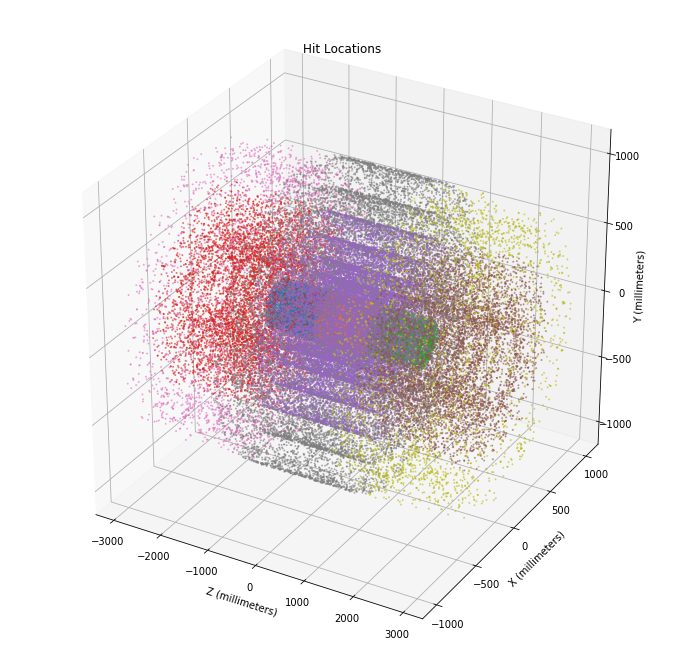

In [12]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')
for volume in volumes:
    v = hits[hits.volume_id == volume]
    ax.scatter(v.z, v.x, v.y, s=1, label='volume {}'.format(volume), alpha=0.5)
ax.set_title('Hit Locations')
ax.set_xlabel('Z (millimeters)')
ax.set_ylabel('X (millimeters)')
ax.set_zlabel('Y (millimeters)')
plt.show()

### Affected Surface Object
The **volume**, **layer** and **module** are nested parts on the detector surface.  The volume is made of layers, which in turn have modules.  Analyzing their response could help us understand if some of them are dead/defective and therefore we may need to account for the bias they cause.

The figure below shows a plot of every combination of `x`, `y`, `volume`, `layer` and `module`.  The colors identify different *volumes*.  Along the main diagonal we have the variables' histograms.

The (`hit_id`, `x`) and (`hit_id`, `y`) pairs show us how different volumes are layered.

This figure idea is taken from [Joshua Bonatt's notebook][josh].

[josh]: https://www.kaggle.com/jbonatt/trackml-eda-etc

/opt/anaconda3/envs/qpr_qiskit/lib/python3.7/site-packages/seaborn/axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


LinAlgError: singular matrix

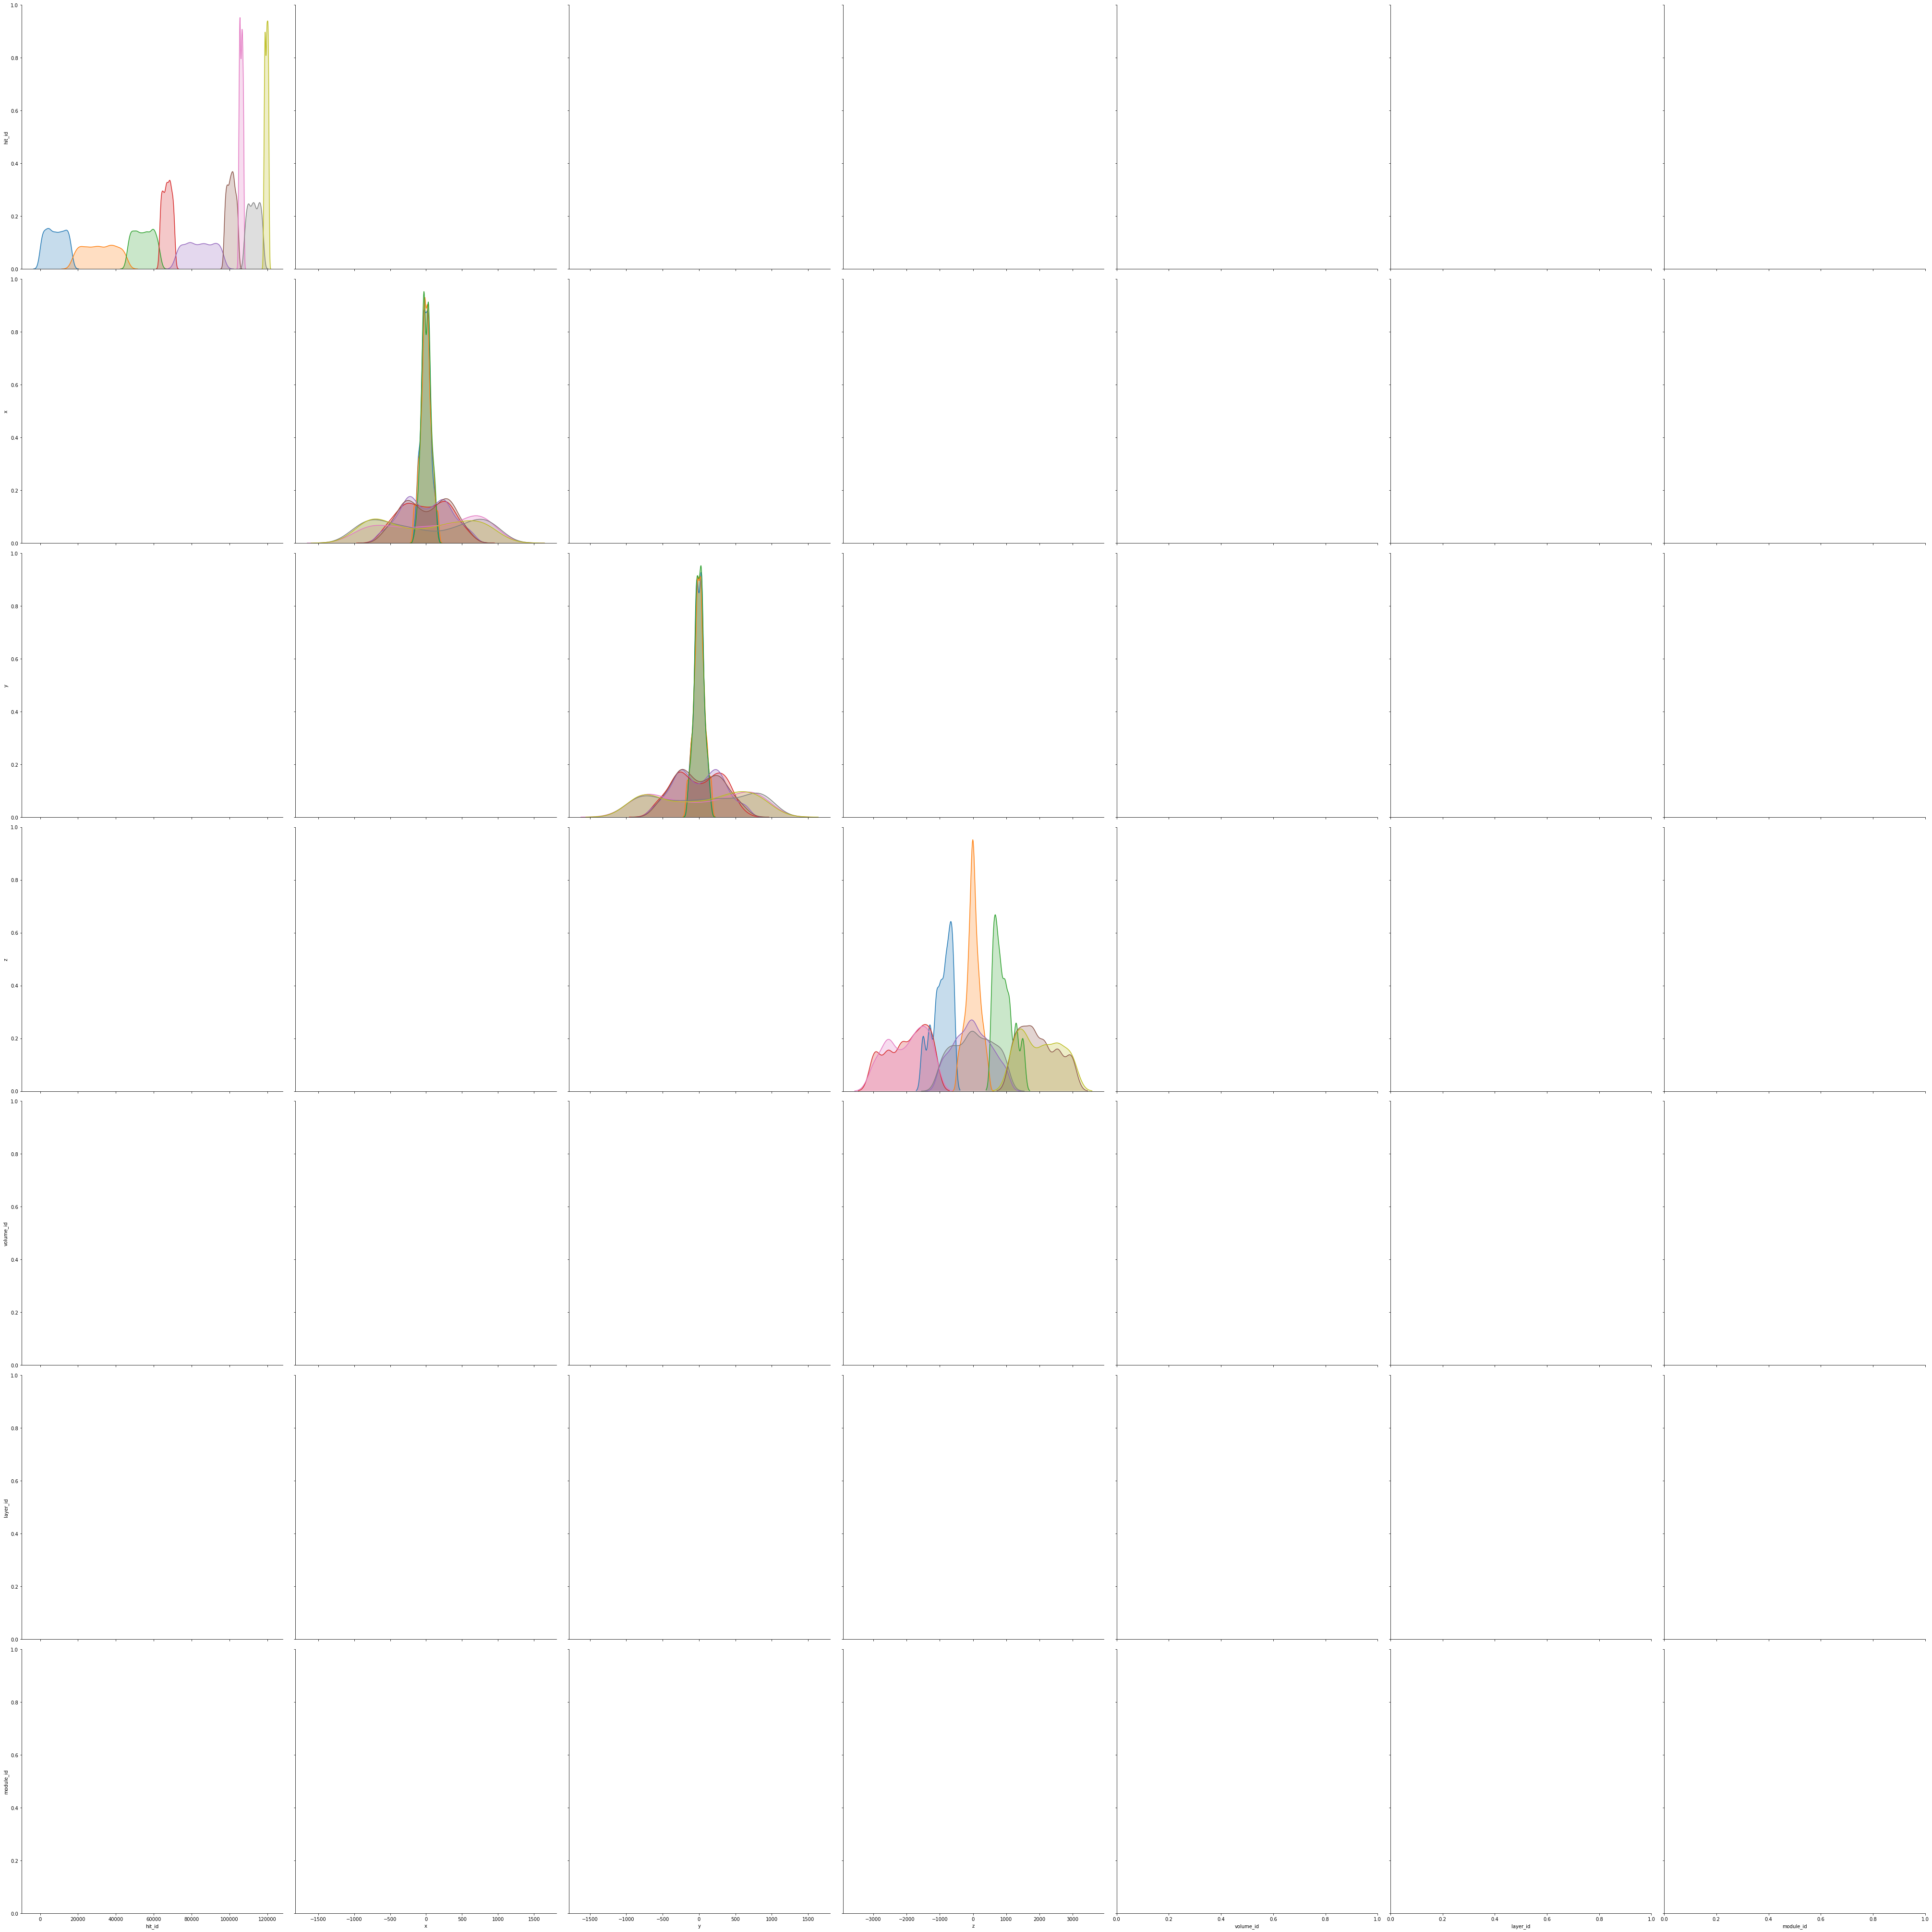

In [13]:
hits_sample = hits.sample(8000)
sns.pairplot(hits_sample, hue='volume_id', size=8)
plt.show()

## Particle Data
The particle data help us understand each particle's initial position, momentum, and charge, which we can join with the event truth data set to get the particle's final position and momentum.  This is needed to identify the tracks that each particle generated.

The data look like this:

In [14]:
particles.head()

,particle_id,vx,vy,vz,px,py,pz,q,nhits
0,4503668346847232,-0.009288,0.009861,-0.077879,-0.055269,0.323272,-0.203492,-1,8
1,4503737066323968,-0.009288,0.009861,-0.077879,-0.948125,0.470892,2.010060,1,11
2,4503805785800704,-0.009288,0.009861,-0.077879,-0.886484,0.105749,0.683881,-1,0
3,4503874505277440,-0.009288,0.009861,-0.077879,0.257539,-0.676718,0.991616,1,12
4,4503943224754176,-0.009288,0.009861,-0.077879,16.439400,-15.548900,-39.824902,1,3


### Hit Rate and Charge Distribution
Let's see the distribution of the number of hits per particle, shown below.  A significant number of particles had no attributed hits, and most of them have positive charge in this event.

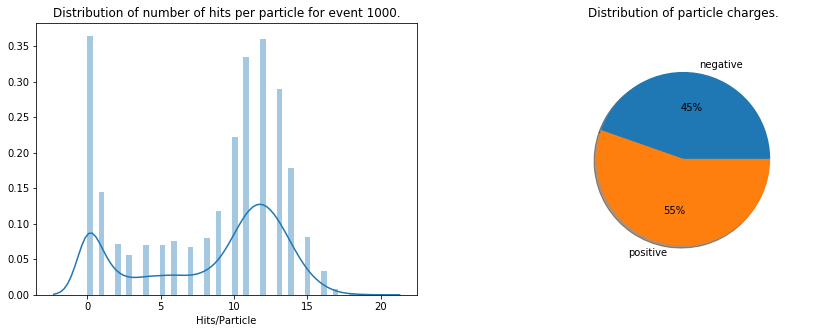

In [15]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.distplot(particles.nhits.values, axlabel='Hits/Particle', bins=50)
plt.title('Distribution of number of hits per particle for event 1000.')
plt.subplot(1, 2, 2)
plt.pie(particles.groupby('q')['vx'].count(),
        labels=['negative', 'positive'],
        autopct='%.0f%%',
        shadow=True,
        radius=0.8)
plt.title('Distribution of particle charges.')
plt.show()

### Initial Position and Momentum
Let's now take a look at the initial position of the particles around the global coordinates' origin $(x, y)=(0,0)$, as shown in the figure below.

The initial position distribution is more concentrated around the origin (less variance) than its hit position (shown above under the Hits Data section).  As the particles hit the detection surface, they tend to scatter as shown in the particle trajectory plot at the end of this notebook.

The colors here show the number of hits for each particle.

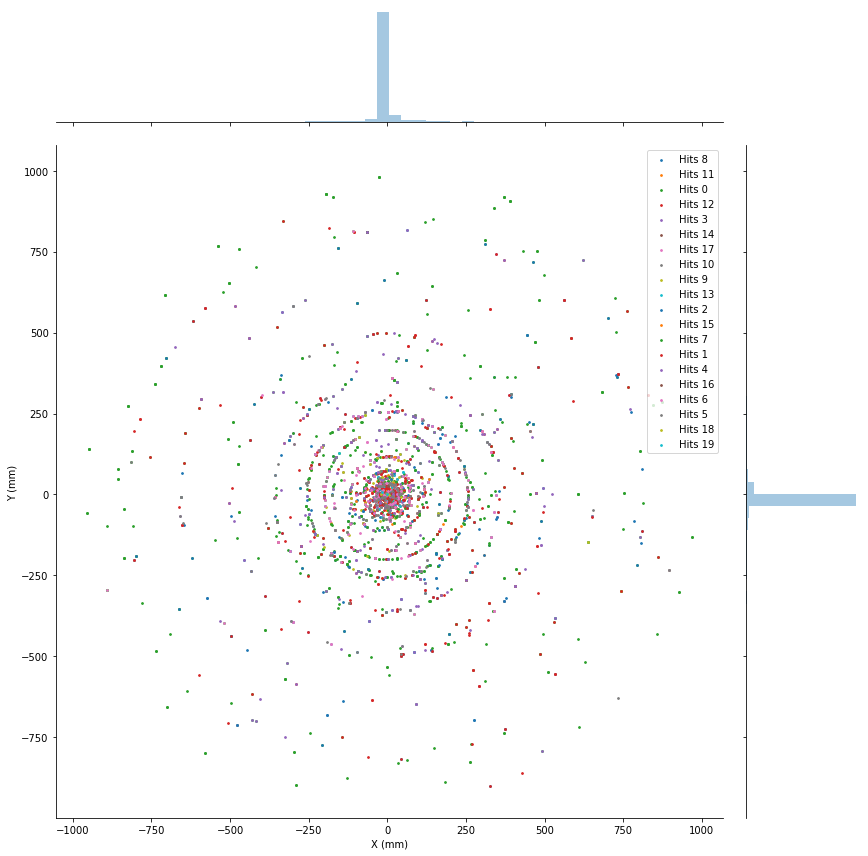

In [16]:
g = sns.jointplot(particles.vx, particles.vy,  s=3, size=12)
g.ax_joint.cla()
plt.sca(g.ax_joint)

n_hits = particles.nhits.unique()
for n_hit in n_hits:
    p = particles[particles.nhits == n_hit]
    plt.scatter(p.vx, p.vy, s=3, label='Hits {}'.format(n_hit))

plt.xlabel('X (mm)')
plt.ylabel('Y (mm)')
plt.legend()
plt.show()

And here is the initial position of the particles in a $z$, $y$ view.  Colors show number of hits.

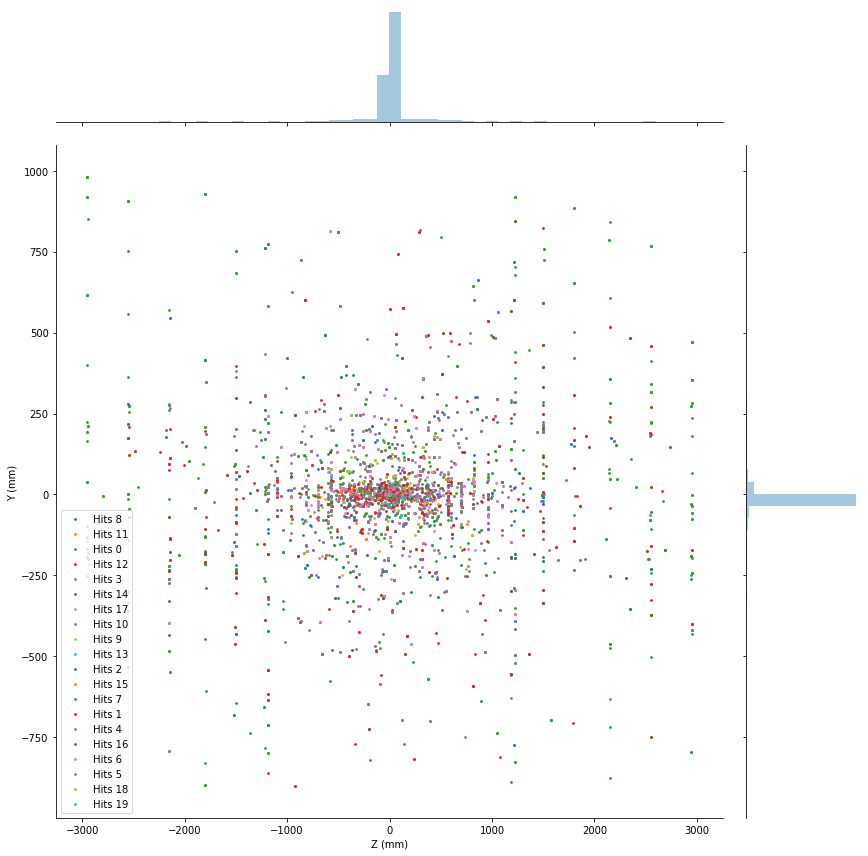

In [17]:
g = sns.jointplot(particles.vz, particles.vy,  s=3, size=12)
g.ax_joint.cla()
plt.sca(g.ax_joint)

n_hits = particles.nhits.unique()
for n_hit in n_hits:
    p = particles[particles.nhits == n_hit]
    plt.scatter(p.vz, p.vy, s=3, label='Hits {}'.format(n_hit))

plt.xlabel('Z (mm)')
plt.ylabel('Y (mm)')
plt.legend()
plt.show()

And this is what they look like in 3D.

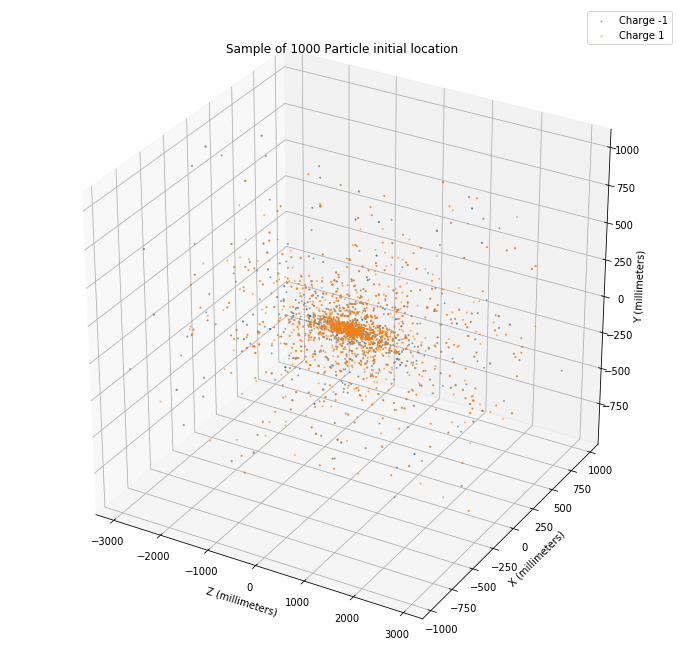

In [18]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')
for charge in [-1, 1]:
    q = particles[particles.q == charge]
    ax.scatter(q.vz, q.vx, q.vy, s=1, label='Charge {}'.format(charge), alpha=0.5)
ax.set_title('Sample of 1000 Particle initial location')
ax.set_xlabel('Z (millimeters)')
ax.set_ylabel('X (millimeters)')
ax.set_zlabel('Y (millimeters)')
ax.legend()
plt.show()

## Pair plot
Let's now take a look at the relationship between different pair combinations of the particle variables.  Again, the colors represent the number of hits.

There is no large skew in the distribution of the number of hits over other variables.  It looks like the particles are targetted towards the global origin $(x,y)=(0,0)$ and are evenly distributed around it.

LinAlgError: singular matrix

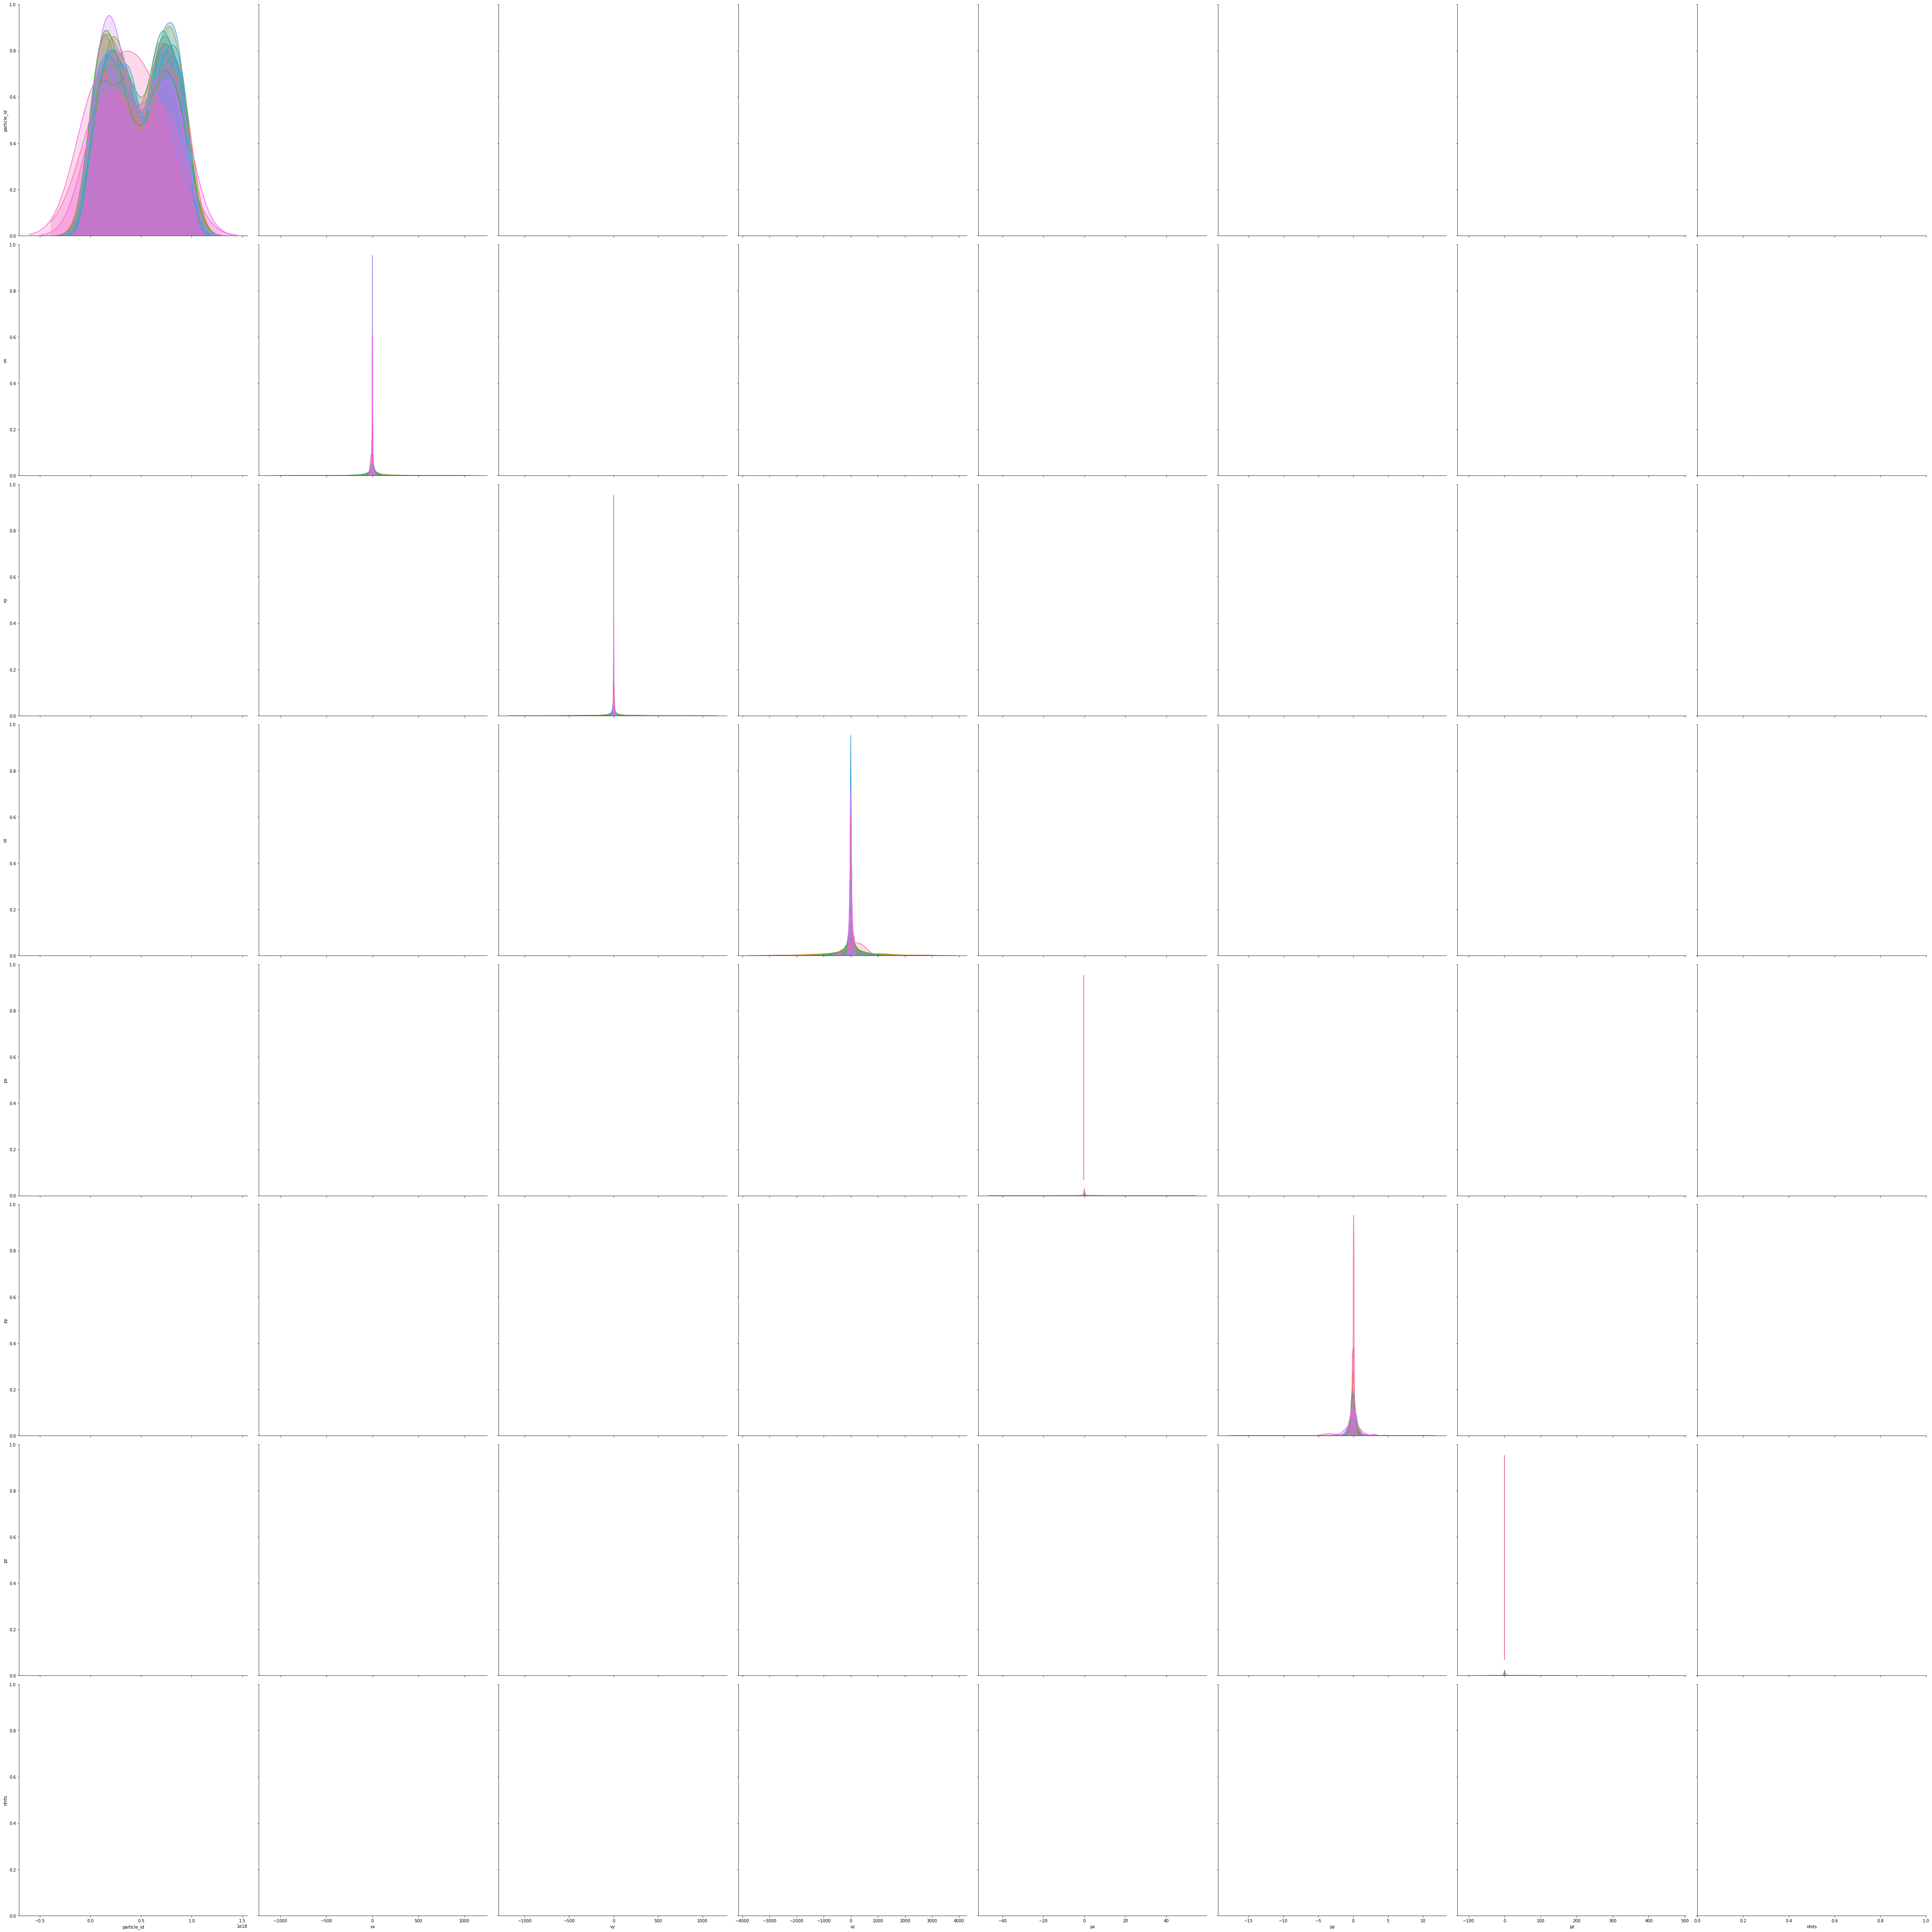

In [20]:
p_sample = particles.sample(8000)
sns.pairplot(p_sample, vars=['particle_id', 'vx', 'vy', 'vz', 'px', 'py', 'pz', 'nhits'], hue='nhits', size=8)
plt.show()

### Particle Trajectory
We can reconstruct the trajectories for a few particles given their intersection points with the detection layers.  As explained in the [competition evaluation page][ceval], hits from straight tracks have larger wieghts, and random tracks or hits with very short tracks have weights of zero.  The figure below shows two such examples.

Thanks to [maka's notebook][traj] for the idea.

[traj]: https://www.kaggle.com/makahana/quick-trajectory-plot
[ceval]: https://www.kaggle.com/c/trackml-particle-identification#evaluation

In [ ]:
# Get particle id with max number of hits in this event
particle = particles.loc[particles.nhits == particles.nhits.max()].iloc[0]
particle2 = particles.loc[particles.nhits == particles.nhits.max()].iloc[1]

# Get points where the same particle intersected subsequent layers of the observation material
p_traj_surface = truth[truth.particle_id == particle.particle_id][['tx', 'ty', 'tz']]
p_traj_surface2 = truth[truth.particle_id == particle2.particle_id][['tx', 'ty', 'tz']]

p_traj = (p_traj_surface
          .append({'tx': particle.vx, 'ty': particle.vy, 'tz': particle.vz}, ignore_index=True)
          .sort_values(by='tz'))
p_traj2 = (p_traj_surface2
          .append({'tx': particle2.vx, 'ty': particle2.vy, 'tz': particle2.vz}, ignore_index=True)
          .sort_values(by='tz'))

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

ax.plot(
    xs=p_traj.tx,
    ys=p_traj.ty,
    zs=p_traj.tz, marker='o')
ax.plot(
    xs=p_traj2.tx,
    ys=p_traj2.ty,
    zs=p_traj2.tz, marker='o')

ax.set_xlabel('X (mm)')
ax.set_ylabel('Y (mm)')
ax.set_zlabel('Z  (mm) -- Detection layers')
plt.title('Trajectories of two particles as they cross the detection surface ($Z$ axis).')
plt.show()